# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

#####################################################################################################################
#----------------------------------------------------- Imports -----------------------------------------------------#
#####################################################################################################################

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

#####################################################################################################################
#---------------------------------------------- Parameter definition -----------------------------------------------#
#####################################################################################################################


## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    train_transform = transforms.Compose([  transforms.Resize(image_size),
                                            transforms.ToTensor()])
    
    train_data = datasets.ImageFolder( data_dir, transform=train_transform )
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 256
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

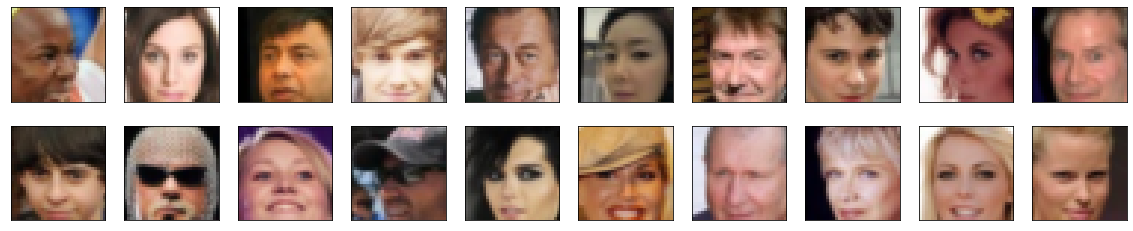

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.9216)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)  
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1): 
        m.weight.data.normal_(0.0, 0.02) 
    if hasattr(m, 'bias') and m.bias is not None: 
        m.bias.data.zero_() 

    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size) *0.9 # real labels = 1
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels) 
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
        
            d_optimizer.zero_grad()
        
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step() 
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 400


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  400] | d_loss: 1.4952 | g_loss: 0.6982
Epoch [    1/  400] | d_loss: 0.5191 | g_loss: 2.4654
Epoch [    1/  400] | d_loss: 0.4855 | g_loss: 2.7523
Epoch [    1/  400] | d_loss: 0.5138 | g_loss: 2.5110
Epoch [    1/  400] | d_loss: 0.8885 | g_loss: 3.5271
Epoch [    1/  400] | d_loss: 0.6995 | g_loss: 1.5991
Epoch [    1/  400] | d_loss: 0.8585 | g_loss: 1.7776
Epoch [    1/  400] | d_loss: 0.9477 | g_loss: 1.5059
Epoch [    2/  400] | d_loss: 0.9044 | g_loss: 1.8356
Epoch [    2/  400] | d_loss: 0.8969 | g_loss: 1.8916
Epoch [    2/  400] | d_loss: 1.0202 | g_loss: 1.1026
Epoch [    2/  400] | d_loss: 1.0707 | g_loss: 1.2751
Epoch [    2/  400] | d_loss: 1.2767 | g_loss: 0.8344
Epoch [    2/  400] | d_loss: 1.1317 | g_loss: 1.0811
Epoch [    2/  400] | d_loss: 1.2205 | g_loss: 0.9130
Epoch [    2/  400] | d_loss: 1.1446 | g_loss: 0.8729
Epoch [    3/  400] | d_loss: 1.2154 | g_loss: 0.8776
Epoch [    3/  400] | d_loss: 1.1688 | g_loss: 0.9195
Epoch [    3/  400] | d_loss

Epoch [   38/  400] | d_loss: 0.7487 | g_loss: 1.6470
Epoch [   38/  400] | d_loss: 0.8471 | g_loss: 2.6458
Epoch [   39/  400] | d_loss: 0.7527 | g_loss: 2.3423
Epoch [   39/  400] | d_loss: 0.6478 | g_loss: 1.5727
Epoch [   39/  400] | d_loss: 0.7312 | g_loss: 1.7755
Epoch [   39/  400] | d_loss: 1.1240 | g_loss: 1.0867
Epoch [   39/  400] | d_loss: 0.6820 | g_loss: 1.5615
Epoch [   39/  400] | d_loss: 0.7161 | g_loss: 1.8128
Epoch [   39/  400] | d_loss: 0.7473 | g_loss: 1.9737
Epoch [   39/  400] | d_loss: 0.6690 | g_loss: 2.1389
Epoch [   40/  400] | d_loss: 0.6269 | g_loss: 1.6244
Epoch [   40/  400] | d_loss: 0.6918 | g_loss: 1.8628
Epoch [   40/  400] | d_loss: 0.6582 | g_loss: 1.4552
Epoch [   40/  400] | d_loss: 0.9692 | g_loss: 2.0137
Epoch [   40/  400] | d_loss: 0.7344 | g_loss: 1.4690
Epoch [   40/  400] | d_loss: 0.7372 | g_loss: 1.4690
Epoch [   40/  400] | d_loss: 0.7422 | g_loss: 1.6372
Epoch [   40/  400] | d_loss: 0.7529 | g_loss: 2.3609
Epoch [   41/  400] | d_loss

Epoch [   76/  400] | d_loss: 0.5132 | g_loss: 2.2410
Epoch [   76/  400] | d_loss: 0.4947 | g_loss: 2.4598
Epoch [   76/  400] | d_loss: 0.5444 | g_loss: 2.2203
Epoch [   76/  400] | d_loss: 0.4744 | g_loss: 2.4950
Epoch [   77/  400] | d_loss: 0.5168 | g_loss: 2.4864
Epoch [   77/  400] | d_loss: 1.5853 | g_loss: 0.7005
Epoch [   77/  400] | d_loss: 0.5310 | g_loss: 2.2683
Epoch [   77/  400] | d_loss: 0.5363 | g_loss: 2.2982
Epoch [   77/  400] | d_loss: 0.6134 | g_loss: 2.2085
Epoch [   77/  400] | d_loss: 0.5105 | g_loss: 2.2961
Epoch [   77/  400] | d_loss: 0.5434 | g_loss: 1.5212
Epoch [   77/  400] | d_loss: 0.5097 | g_loss: 2.4310
Epoch [   78/  400] | d_loss: 0.4789 | g_loss: 2.9197
Epoch [   78/  400] | d_loss: 0.5053 | g_loss: 2.1537
Epoch [   78/  400] | d_loss: 0.5648 | g_loss: 2.1309
Epoch [   78/  400] | d_loss: 0.5621 | g_loss: 2.4169
Epoch [   78/  400] | d_loss: 0.5528 | g_loss: 2.1731
Epoch [   78/  400] | d_loss: 0.6808 | g_loss: 2.8479
Epoch [   78/  400] | d_loss

Epoch [  114/  400] | d_loss: 0.9145 | g_loss: 1.4269
Epoch [  114/  400] | d_loss: 0.6191 | g_loss: 2.4190
Epoch [  114/  400] | d_loss: 0.4962 | g_loss: 2.0162
Epoch [  114/  400] | d_loss: 0.4593 | g_loss: 2.8455
Epoch [  114/  400] | d_loss: 0.4607 | g_loss: 2.2051
Epoch [  114/  400] | d_loss: 0.4337 | g_loss: 2.8080
Epoch [  115/  400] | d_loss: 0.4643 | g_loss: 3.1070
Epoch [  115/  400] | d_loss: 0.4395 | g_loss: 3.7657
Epoch [  115/  400] | d_loss: 0.5180 | g_loss: 2.2673
Epoch [  115/  400] | d_loss: 0.4443 | g_loss: 3.1326
Epoch [  115/  400] | d_loss: 0.6020 | g_loss: 1.8135
Epoch [  115/  400] | d_loss: 1.2271 | g_loss: 1.3101
Epoch [  115/  400] | d_loss: 1.8818 | g_loss: 0.5415
Epoch [  115/  400] | d_loss: 0.5412 | g_loss: 2.3870
Epoch [  116/  400] | d_loss: 0.4474 | g_loss: 3.0731
Epoch [  116/  400] | d_loss: 0.4541 | g_loss: 3.2752
Epoch [  116/  400] | d_loss: 0.4524 | g_loss: 2.7670
Epoch [  116/  400] | d_loss: 0.4608 | g_loss: 3.1720
Epoch [  116/  400] | d_loss

Epoch [  152/  400] | d_loss: 0.3932 | g_loss: 3.3307
Epoch [  152/  400] | d_loss: 0.3946 | g_loss: 4.1306
Epoch [  152/  400] | d_loss: 0.6797 | g_loss: 4.0062
Epoch [  152/  400] | d_loss: 0.4570 | g_loss: 3.0954
Epoch [  152/  400] | d_loss: 0.4239 | g_loss: 3.4356
Epoch [  152/  400] | d_loss: 0.5755 | g_loss: 1.9389
Epoch [  152/  400] | d_loss: 1.5289 | g_loss: 1.2102
Epoch [  152/  400] | d_loss: 0.4506 | g_loss: 2.7905
Epoch [  153/  400] | d_loss: 0.4876 | g_loss: 2.5562
Epoch [  153/  400] | d_loss: 0.3993 | g_loss: 3.9711
Epoch [  153/  400] | d_loss: 0.7239 | g_loss: 2.0753
Epoch [  153/  400] | d_loss: 0.4263 | g_loss: 3.3124
Epoch [  153/  400] | d_loss: 0.4368 | g_loss: 2.9903
Epoch [  153/  400] | d_loss: 0.4319 | g_loss: 3.0448
Epoch [  153/  400] | d_loss: 0.4515 | g_loss: 2.1577
Epoch [  153/  400] | d_loss: 0.3993 | g_loss: 3.1989
Epoch [  154/  400] | d_loss: 0.4042 | g_loss: 2.9612
Epoch [  154/  400] | d_loss: 0.4022 | g_loss: 3.5809
Epoch [  154/  400] | d_loss

Epoch [  189/  400] | d_loss: 0.4505 | g_loss: 1.9947
Epoch [  189/  400] | d_loss: 0.4124 | g_loss: 3.5913
Epoch [  190/  400] | d_loss: 0.3983 | g_loss: 3.7388
Epoch [  190/  400] | d_loss: 0.3892 | g_loss: 4.4410
Epoch [  190/  400] | d_loss: 0.4192 | g_loss: 3.7179
Epoch [  190/  400] | d_loss: 0.4558 | g_loss: 3.1532
Epoch [  190/  400] | d_loss: 0.4191 | g_loss: 3.3802
Epoch [  190/  400] | d_loss: 0.4100 | g_loss: 3.4515
Epoch [  190/  400] | d_loss: 0.4121 | g_loss: 2.9017
Epoch [  190/  400] | d_loss: 0.4054 | g_loss: 4.0647
Epoch [  191/  400] | d_loss: 0.3929 | g_loss: 2.9902
Epoch [  191/  400] | d_loss: 0.4067 | g_loss: 4.2739
Epoch [  191/  400] | d_loss: 0.4021 | g_loss: 3.8900
Epoch [  191/  400] | d_loss: 0.4048 | g_loss: 3.8925
Epoch [  191/  400] | d_loss: 0.4164 | g_loss: 3.6078
Epoch [  191/  400] | d_loss: 0.4501 | g_loss: 3.1606
Epoch [  191/  400] | d_loss: 0.4241 | g_loss: 2.9282
Epoch [  191/  400] | d_loss: 0.3873 | g_loss: 4.1468
Epoch [  192/  400] | d_loss

Epoch [  227/  400] | d_loss: 0.3974 | g_loss: 3.9274
Epoch [  227/  400] | d_loss: 0.4169 | g_loss: 2.9695
Epoch [  227/  400] | d_loss: 0.3957 | g_loss: 3.2860
Epoch [  227/  400] | d_loss: 0.3975 | g_loss: 3.9924
Epoch [  228/  400] | d_loss: 0.3996 | g_loss: 3.4667
Epoch [  228/  400] | d_loss: 0.3876 | g_loss: 4.6231
Epoch [  228/  400] | d_loss: 0.3865 | g_loss: 3.6624
Epoch [  228/  400] | d_loss: 0.3873 | g_loss: 4.0330
Epoch [  228/  400] | d_loss: 0.4016 | g_loss: 3.7450
Epoch [  228/  400] | d_loss: 0.6947 | g_loss: 3.6199
Epoch [  228/  400] | d_loss: 0.4069 | g_loss: 3.2323
Epoch [  228/  400] | d_loss: 0.3947 | g_loss: 4.1947
Epoch [  229/  400] | d_loss: 0.3898 | g_loss: 3.3741
Epoch [  229/  400] | d_loss: 0.3786 | g_loss: 4.4000
Epoch [  229/  400] | d_loss: 0.4320 | g_loss: 3.2255
Epoch [  229/  400] | d_loss: 0.3975 | g_loss: 4.3565
Epoch [  229/  400] | d_loss: 0.3914 | g_loss: 3.6532
Epoch [  229/  400] | d_loss: 0.3956 | g_loss: 3.2536
Epoch [  229/  400] | d_loss

Epoch [  265/  400] | d_loss: 0.4188 | g_loss: 3.4810
Epoch [  265/  400] | d_loss: 0.3915 | g_loss: 4.2284
Epoch [  265/  400] | d_loss: 0.4423 | g_loss: 4.5417
Epoch [  265/  400] | d_loss: 0.4257 | g_loss: 3.6227
Epoch [  265/  400] | d_loss: 0.4188 | g_loss: 2.6219
Epoch [  265/  400] | d_loss: 0.4046 | g_loss: 3.7726
Epoch [  266/  400] | d_loss: 0.4031 | g_loss: 3.6763
Epoch [  266/  400] | d_loss: 0.4079 | g_loss: 5.0286
Epoch [  266/  400] | d_loss: 0.4288 | g_loss: 3.3558
Epoch [  266/  400] | d_loss: 0.3971 | g_loss: 4.3364
Epoch [  266/  400] | d_loss: 0.4066 | g_loss: 3.3736
Epoch [  266/  400] | d_loss: 0.4324 | g_loss: 3.6139
Epoch [  266/  400] | d_loss: 0.4092 | g_loss: 2.5055
Epoch [  266/  400] | d_loss: 0.3785 | g_loss: 4.3934
Epoch [  267/  400] | d_loss: 0.4080 | g_loss: 3.1859
Epoch [  267/  400] | d_loss: 0.4150 | g_loss: 4.5938
Epoch [  267/  400] | d_loss: 0.3870 | g_loss: 4.4129
Epoch [  267/  400] | d_loss: 0.3997 | g_loss: 4.4979
Epoch [  267/  400] | d_loss

Epoch [  303/  400] | d_loss: 0.3913 | g_loss: 3.4845
Epoch [  303/  400] | d_loss: 0.4451 | g_loss: 4.9583
Epoch [  303/  400] | d_loss: 0.3916 | g_loss: 4.5259
Epoch [  303/  400] | d_loss: 0.3841 | g_loss: 4.5007
Epoch [  303/  400] | d_loss: 4.7298 | g_loss: 0.5661
Epoch [  303/  400] | d_loss: 0.4340 | g_loss: 3.2846
Epoch [  303/  400] | d_loss: 0.4207 | g_loss: 2.9367
Epoch [  303/  400] | d_loss: 0.3807 | g_loss: 3.8764
Epoch [  304/  400] | d_loss: 0.3930 | g_loss: 3.3571
Epoch [  304/  400] | d_loss: 0.4049 | g_loss: 4.7433
Epoch [  304/  400] | d_loss: 0.4088 | g_loss: 4.4074
Epoch [  304/  400] | d_loss: 0.3833 | g_loss: 4.1416
Epoch [  304/  400] | d_loss: 0.3888 | g_loss: 3.8936
Epoch [  304/  400] | d_loss: 0.6462 | g_loss: 2.1064
Epoch [  304/  400] | d_loss: 0.4173 | g_loss: 3.6425
Epoch [  304/  400] | d_loss: 0.4892 | g_loss: 4.0649
Epoch [  305/  400] | d_loss: 0.6045 | g_loss: 1.0659
Epoch [  305/  400] | d_loss: 0.4107 | g_loss: 4.4270
Epoch [  305/  400] | d_loss

Epoch [  340/  400] | d_loss: 0.3860 | g_loss: 2.4276
Epoch [  340/  400] | d_loss: 0.3861 | g_loss: 3.9862
Epoch [  341/  400] | d_loss: 0.3825 | g_loss: 3.8739
Epoch [  341/  400] | d_loss: 0.3899 | g_loss: 4.9447
Epoch [  341/  400] | d_loss: 0.3747 | g_loss: 3.5294
Epoch [  341/  400] | d_loss: 0.3699 | g_loss: 4.6205
Epoch [  341/  400] | d_loss: 0.4769 | g_loss: 2.5040
Epoch [  341/  400] | d_loss: 0.8872 | g_loss: 1.4308
Epoch [  341/  400] | d_loss: 0.4122 | g_loss: 3.4245
Epoch [  341/  400] | d_loss: 0.4334 | g_loss: 4.5445
Epoch [  342/  400] | d_loss: 0.4111 | g_loss: 2.9272
Epoch [  342/  400] | d_loss: 0.4230 | g_loss: 4.6010
Epoch [  342/  400] | d_loss: 0.3831 | g_loss: 3.8489
Epoch [  342/  400] | d_loss: 0.3816 | g_loss: 4.3355
Epoch [  342/  400] | d_loss: 0.3979 | g_loss: 3.3216
Epoch [  342/  400] | d_loss: 0.3932 | g_loss: 4.2615
Epoch [  342/  400] | d_loss: 0.4032 | g_loss: 3.0082
Epoch [  342/  400] | d_loss: 0.3697 | g_loss: 4.5436
Epoch [  343/  400] | d_loss

Epoch [  378/  400] | d_loss: 0.4493 | g_loss: 3.5929
Epoch [  378/  400] | d_loss: 0.4133 | g_loss: 3.9984
Epoch [  378/  400] | d_loss: 0.4622 | g_loss: 3.0243
Epoch [  378/  400] | d_loss: 0.3838 | g_loss: 4.8843
Epoch [  379/  400] | d_loss: 0.3926 | g_loss: 4.0159
Epoch [  379/  400] | d_loss: 0.3845 | g_loss: 4.7080
Epoch [  379/  400] | d_loss: 0.3800 | g_loss: 4.3848
Epoch [  379/  400] | d_loss: 0.3641 | g_loss: 4.8125
Epoch [  379/  400] | d_loss: 0.4155 | g_loss: 2.8430
Epoch [  379/  400] | d_loss: 0.3805 | g_loss: 4.1881
Epoch [  379/  400] | d_loss: 0.3672 | g_loss: 3.7327
Epoch [  379/  400] | d_loss: 0.6238 | g_loss: 2.4855
Epoch [  380/  400] | d_loss: 0.6386 | g_loss: 2.0302
Epoch [  380/  400] | d_loss: 0.4009 | g_loss: 4.9505
Epoch [  380/  400] | d_loss: 0.4081 | g_loss: 3.5450
Epoch [  380/  400] | d_loss: 0.3911 | g_loss: 4.4924
Epoch [  380/  400] | d_loss: 0.4697 | g_loss: 3.8979
Epoch [  380/  400] | d_loss: 0.3892 | g_loss: 4.1753
Epoch [  380/  400] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

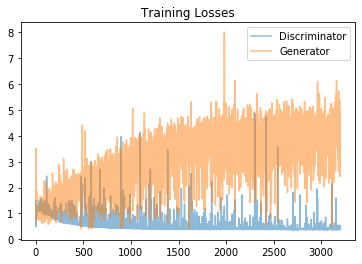

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

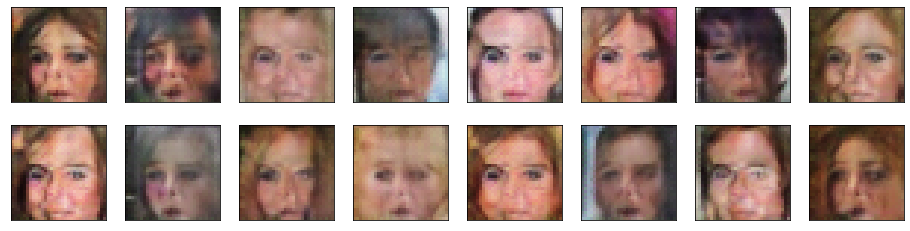

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
The data set should contain pictures of people of all nations, ethnicities and different ages. The networks have only 6 layers. If this number is increased, individual features can be learned better.  The resolution of the images should not be reduced to 32x32 pixels to reduce  blurring.
The training was conducted with different number of epochs (10,20,60,100 and 400 epochs). Training loss and sample images are stored in the git repository. The best results were achieved at 100 epochs. At approx. 200 epochs a plateau is reached. To improve the results a hyperparameter tuning could be performed.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.